In [ ]:
pip install matplotlib pillow sklearn opencv-python tqdm pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=24c194ddaf77ae1e2bc1686ca2dc06d818eb6194eaeba97d4e0ca385cd391373
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [3]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

# Utility functions

In [7]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

def build_model_transfer(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

# Densenet - Baseline model

In [ ]:
densenet = DenseNet121(
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

29097984/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


# Import Data flow

In [5]:
base_path = '/Users/vishnu/Work/uni/VISOPE/deepfake-image-detector/dataset/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
train_steps = 1000//64
valid_steps = 200//64

earlystop_callback = EarlyStopping(monitor='loss', patience=3)
checkpoint_callback = ModelCheckpoint(filepath=f"model.hdf5", 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

history = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6927 
Epoch 1: val_loss improved from inf to 0.66037, saving model to model.hdf5
15/15 [==============================] - 1095s 72s/step - loss: 0.6528 - accuracy: 0.6927 - val_loss: 0.6604 - val_accuracy: 0.6406
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7563 
Epoch 2: val_loss did not improve from 0.66037
15/15 [==============================] - 1060s 72s/step - loss: 0.5222 - accuracy: 0.7563 - val_loss: 3.0993 - val_accuracy: 0.5052
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.7948 
Epoch 3: val_loss did not improve from 0.66037
15/15 [==============================] - 1052s 71s/step - loss: 0.4340 - accuracy: 0.7948 - val_loss: 9.9671 - val_accuracy: 0.4896
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8406 
Epoch 4: val_loss did not improve from 0.66037
15/15 [=

In [ ]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


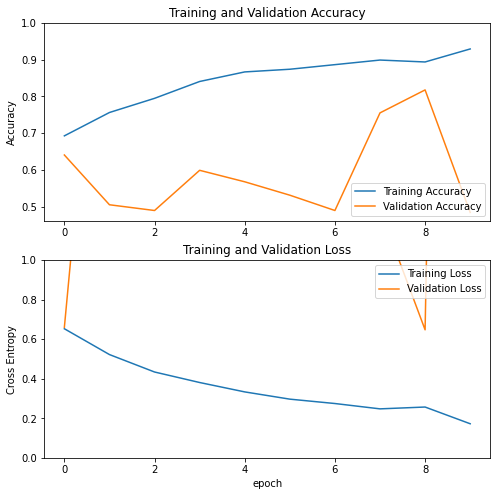

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Resnet50 - Transfer Learning - Baseline model

In [8]:
densenet.trainable = False
model = build_model_transfer(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [11]:
history_tf = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.4927
Epoch 1: val_loss improved from inf to 0.72470, saving model to model.hdf5
15/15 [==============================] - 74s 5s/step - loss: 0.7754 - accuracy: 0.4927 - val_loss: 0.7247 - val_accuracy: 0.5260
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.5406
Epoch 2: val_loss improved from 0.72470 to 0.69337, saving model to model.hdf5
15/15 [==============================] - 68s 5s/step - loss: 0.7299 - accuracy: 0.5406 - val_loss: 0.6934 - val_accuracy: 0.5260
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.6094
Epoch 3: val_loss improved from 0.69337 to 0.61192, saving model to model.hdf5
15/15 [==============================] - 65s 4s/step - loss: 0.6608 - accuracy: 0.6094 - val_loss: 0.6119 - val_accuracy: 0.6823
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6187
Epoc

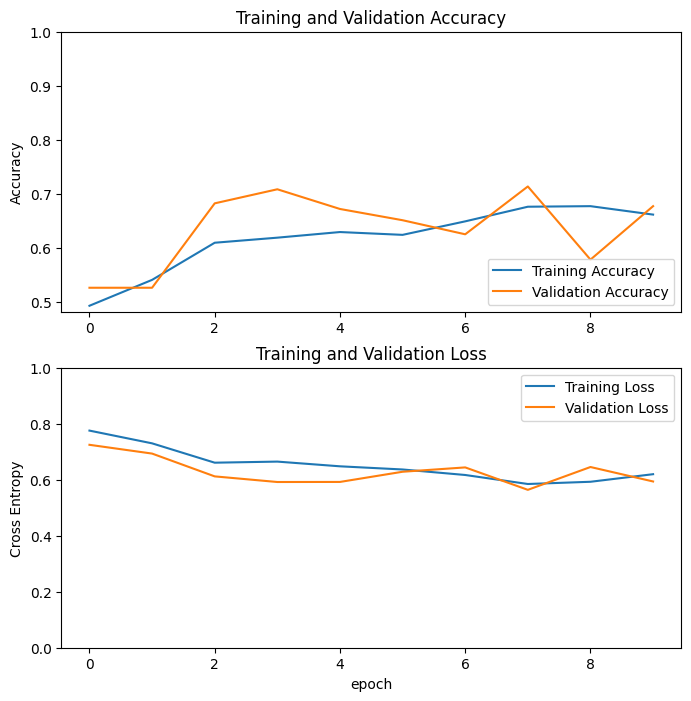

In [12]:
acc = history_tf.history['accuracy']
val_acc = history_tf.history['val_accuracy']

loss = history_tf.history['loss']
val_loss = history_tf.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Resnet50 - Transfer Learning - Fine tuned model

In [17]:
print("Number of layers in the base model: ", len(densenet.layers))

densenet.trainable = True

fine_tune_at = 370

# Freeze all the layers before the `fine_tune_at` layer
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable = False


model = build_model_transfer(densenet)
model.summary()

Number of layers in the base model:  427
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,213,697
Non-trainable params: 5,824,832
_________________________________________________________________


In [18]:
history_tf_ft = model.fit(
      train_flow,
      epochs=10,
      steps_per_epoch = train_steps,
      validation_data = valid_flow,
      validation_steps = valid_steps,
      callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.6927
Epoch 1: val_loss improved from 0.56388 to 0.56216, saving model to model.hdf5
15/15 [==============================] - 74s 5s/step - loss: 0.5784 - accuracy: 0.6927 - val_loss: 0.5622 - val_accuracy: 0.7396
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.7729
Epoch 2: val_loss improved from 0.56216 to 0.52324, saving model to model.hdf5
15/15 [==============================] - 69s 5s/step - loss: 0.5031 - accuracy: 0.7729 - val_loss: 0.5232 - val_accuracy: 0.7500
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.8052
Epoch 3: val_loss improved from 0.52324 to 0.41696, saving model to model.hdf5
15/15 [==============================] - 69s 5s/step - loss: 0.4246 - accuracy: 0.8052 - val_loss: 0.4170 - val_accuracy: 0.8385
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8208


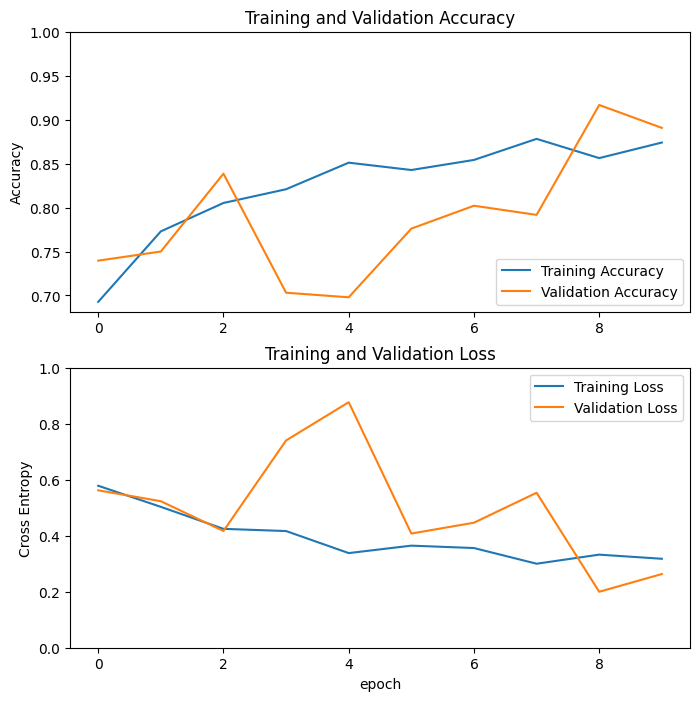

In [20]:
acc = history_tf_ft.history['accuracy']
val_acc = history_tf_ft.history['val_accuracy']

loss = history_tf_ft.history['loss']
val_loss = history_tf_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

20000/20000 [==============================] - 2036s 102ms/step


In [22]:
from sklearn import metrics

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))

print("AP Score:", metrics.average_precision_score(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.954588925
AP Score: 0.9553239217059304
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     10000
           1       0.90      0.86      0.88     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

